In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'ZPYL4KTSVYKRT2P0Y4PZQJJXENSMUPCLBOWMQPFLZ3Q3L5U5' # your Foursquare ID
CLIENT_SECRET = 'H4CE4PCVTLNMEKAUOX5UJNFOAXTOQTBDOVUXGH300GOBGUUE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [7]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [11]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
ny_data.shape

(306, 4)

## Initial Data Analysis

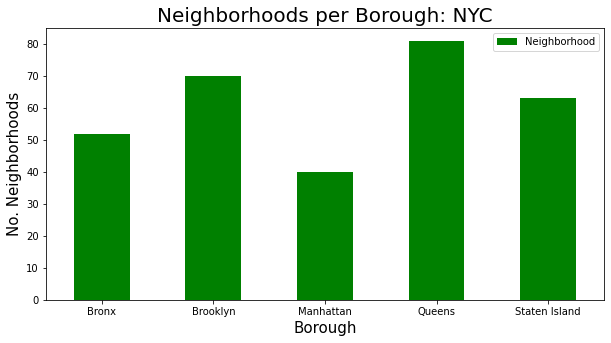

In [13]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


## Let's analyze further and see how many Japanese restaurants there are in each neighborhood and borough. After it, graph the results.

In [14]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

( 67 / 306 ) Japanese Restaurants in Carroll Gardens, Brooklyn:1
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Japanese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Japanese Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Japanese Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Japanese Restaurants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Japanese Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Japanese Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Japanese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758

( 130 / 306 ) Japanese Restaurants in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Japanese Restaurants in Woodside, Queens:1
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Japanese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Japanese Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Japanese Restaurants in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Japanese Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Japanese Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Japanese Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Japan

( 196 / 306 ) Japanese Restaurants in North Corona, Queens:0
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Japanese Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Japanese Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Japanese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Japanese Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Japanese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Japanese Restaurants in West Brighton, Staten Island:1
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Japanese Restaurants in Grymes H

( 256 / 306 ) Japanese Restaurants in Emerson Hill, Staten Island:0
['Staten Island', 'Emerson Hill', 40.606794394801, -74.09776206972522]
( 257 / 306 ) Japanese Restaurants in Randall Manor, Staten Island:0
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
( 258 / 306 ) Japanese Restaurants in Howland Hook, Staten Island:0
['Staten Island', 'Howland Hook', 40.63843283794795, -74.18622331749823]
( 259 / 306 ) Japanese Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Japanese Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Japanese Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Japanese Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Japanese Restaurants in Mill Basin,

In [15]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [16]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
57,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
58,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
59,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
60,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
61,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [17]:
japanese_rest_ny.shape

(62, 4)

We got 75 Japanese Restaurants across the New York City.

As we continue our analysis, we see below that although Manhattan had the least number of neighborhoods, it does have the highest number of Japanese restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Murray Hill has the highest number of Japanese restaurants in all of NYC and is actually located in the boroughs of Manhattan and Queens

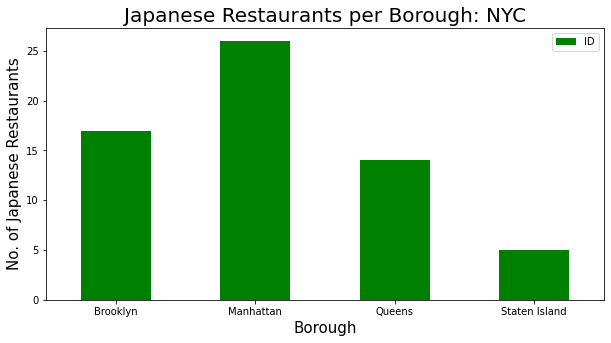

In [18]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

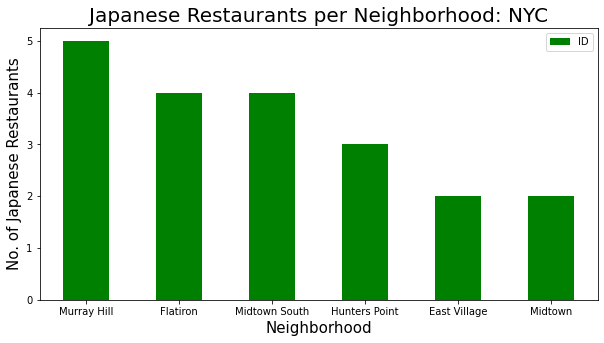

In [19]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [20]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
20,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
21,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
22,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
23,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
36,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


So the Murray Hill in Manhattan has the highest number of Japanese Restaurants with a total count of 5.

Now we will get the ranking of each restaurant for further analysis.

In [21]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60b6eec91b7a593fe5a7ae3e'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

{'meta': {'code': 200, 'requestId': '60b6eecafdfccd30fb6acd16'}, 'response': {'venue': {'id': '5cb5e5f9a35f4600255406c6', 'name': 'Maison Yaki', 'contact': {'phone': '7185522609', 'formattedPhone': '(718) 552-2609', 'twitter': 'maisonyaki', 'instagram': 'maisonyaki', 'facebook': '272996516936741', 'facebookUsername': 'maisonyaki', 'facebookName': 'Maison Yaki'}, 'location': {'address': '626 Vanderbilt Ave', 'crossStreet': 'Prospect Place', 'lat': 40.67747521328162, 'lng': -73.96908078141962, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67747521328162, 'lng': -73.96908078141962}], 'postalCode': '11238', 'cc': 'US', 'neighborhood': 'Prospect Heights', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['626 Vanderbilt Ave (Prospect Place)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/maison-yaki/5cb5e5f9a35f4600255406c6', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName

{'meta': {'code': 200, 'requestId': '60b6eecacb70006492637220'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '60b6eecbb1b0ae09f267ea4b'}, 'response': {'venue': {'id': '5b3bcb69bfc6d0002ca9bf17', 'name': 'Warude', 'contact': {}, 'location': {'address': '387 Tompkins', 'lat': 40.684409678801586, 'lng': -73.94411847251774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.684409678801586, 'lng': -73.94411847251774}], 'postalCode': '11216', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['387 Tompkins', 'New York, NY 11216', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/warude/5b3bcb69bfc6d0002ca9bf17', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss

{'meta': {'code': 200, 'requestId': '60b6eecbaf251f0bbc398e6d'}, 'response': {'venue': {'id': '479ccb47f964a5206b4d1fe3', 'name': 'Iron Chef House', 'contact': {'phone': '7188588517', 'formattedPhone': '(718) 858-8517', 'facebook': '115805155108798', 'facebookUsername': 'IronChefHouse', 'facebookName': 'Iron Chef House'}, 'location': {'address': '92 Clark St', 'crossStreet': 'Henry St', 'lat': 40.697405738767394, 'lng': -73.99256031665585, 'labeledLatLngs': [{'label': 'display', 'lat': 40.697405738767394, 'lng': -73.99256031665585}, {'label': 'entrance', 'lat': 40.69726, 'lng': -73.992604}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['92 Clark St (Henry St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/iron-chef-house/479ccb47f964a5206b4d1fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName'

{'meta': {'code': 200, 'requestId': '60b6eeccdcdbda54cdaa7ace'}, 'response': {'venue': {'id': '48a41073f964a52091511fe3', 'name': 'Hibino', 'contact': {'phone': '7182608052', 'formattedPhone': '(718) 260-8052', 'twitter': 'hibino_brooklyn', 'facebook': '301149720034179', 'facebookUsername': 'hibinobklyn', 'facebookName': 'Hibino Brooklyn'}, 'location': {'address': '333 Henry St', 'crossStreet': 'at Pacific St', 'lat': 40.69007601730789, 'lng': -73.99649744997076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69007601730789, 'lng': -73.99649744997076}, {'label': 'entrance', 'lat': 40.690164, 'lng': -73.996383}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Henry St (at Pacific St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino/48a41073f964a52091511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Rest

{'meta': {'code': 200, 'requestId': '60b6eecdc3d6c5781d33a67a'}, 'response': {'venue': {'id': '5e4f270b03b7910008721f2e', 'name': 'Karazishi Botan', 'contact': {'phone': '3477631155', 'formattedPhone': '(347) 763-1155', 'instagram': 'karazishi_botan', 'facebook': '110365083873021', 'facebookUsername': 'KarazishiBotanBKLYN', 'facebookName': 'Karazishi Botan'}, 'location': {'address': '255 Smith St', 'crossStreet': 'Degraw St', 'lat': 40.683154, 'lng': -73.992888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683154, 'lng': -73.992888}], 'postalCode': '11231', 'cc': 'US', 'neighborhood': 'Boerum Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['255 Smith St (Degraw St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/karazishi-botan/5e4f270b03b7910008721f2e', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon'

{'meta': {'code': 200, 'requestId': '60b6eecd1d9d4e7451f8a54c'}, 'response': {'venue': {'id': '5276d39a498eb1a5d90096e4', 'name': 'Sushi Katsuei', 'contact': {'phone': '7187885338', 'formattedPhone': '(718) 788-5338', 'instagram': 'sushikatsuei', 'facebook': '566743240069984', 'facebookUsername': 'SushiKatsuei', 'facebookName': 'Sushi Katsuei'}, 'location': {'address': '210 7th Ave', 'crossStreet': 'at 3rd St', 'lat': 40.67061519402922, 'lng': -73.97850388946965, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67061519402922, 'lng': -73.97850388946965}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 7th Ave (at 3rd St)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-katsuei/5276d39a498eb1a5d90096e4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'htt

{'meta': {'code': 200, 'requestId': '60b6eecedb321b25f73e2a3b'}, 'response': {'venue': {'id': '4e3cadcb1f6e844231dbe017', 'name': 'Waza', 'contact': {'phone': '7183999292', 'formattedPhone': '(718) 399-9292'}, 'location': {'address': '485 Myrtle Ave', 'lat': 40.693487522158414, 'lng': -73.965735666986, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693487522158414, 'lng': -73.965735666986}, {'label': 'entrance', 'lat': 40.693575, 'lng': -73.965731}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['485 Myrtle Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/waza/4e3cadcb1f6e844231dbe017', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '60b6eecea5bf3b7c74508e9e'}, 'response': {'venue': {'id': '5946d138e2da1964625ca9b2', 'name': 'Daigo Hand Roll Bar', 'contact': {}, 'location': {'address': '445 Albee Sq W', 'lat': 40.69125894731662, 'lng': -73.98260299755893, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69125894731662, 'lng': -73.98260299755893}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq W', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/daigo-hand-roll-bar/5946d138e2da1964625ca9b2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'https://www.daigohandrollbar.com', 'price': {'tier': 2, 'messag

{'meta': {'code': 200, 'requestId': '60b6eecf0f3e894e20f81eb5'}, 'response': {'venue': {'id': '58a202a25490d30f87553a08', 'name': 'Rice & Miso', 'contact': {'phone': '9292793488', 'formattedPhone': '(929) 279-3488', 'twitter': 'riceandmiso', 'instagram': 'riceandmisoeveryday'}, 'location': {'address': '134 Nevins St', 'lat': 40.68463349074915, 'lng': -73.9837684857605, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68463349074915, 'lng': -73.9837684857605}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['134 Nevins St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rice--miso/58a202a25490d30f87553a08', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '60b6eed07a4c740b07b54ca5'}, 'response': {'venue': {'id': '4c7f0887fb74236a7727f9b9', 'name': 'Samurai Mama', 'contact': {'phone': '7185996161', 'formattedPhone': '(718) 599-6161'}, 'location': {'address': '205 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71411421938972, 'lng': -73.96019631848635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71411421938972, 'lng': -73.96019631848635}, {'label': 'entrance', 'lat': 40.714135, 'lng': -73.960149}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['205 Grand St (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samurai-mama/4c7f0887fb74236a7727f9b9', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '60b6eed001e5b15433934ff4'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '60b6eed187bfd807c8a2e2d8'}, 'response': {'venue': {'id': '4c2678eef1272d7f43a986c5', 'name': 'Fushimi', 'contact': {'phone': '7188337788', 'formattedPhone': '(718) 833-7788', 'twitter': 'fushimi_ny', 'facebook': '1885597118324660', 'facebookUsername': 'fushimibayridge', 'facebookName': 'Fushimi Japanese Cuisine & Lounge'}, 'location': {'address': '9316 4th Ave', 'crossStreet': 'btwn 93rd & 94th St', 'lat': 40.61727, 'lng': -74.03101, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61727, 'lng': -74.03101}, {'label': 'entrance', 'lat': 40.61725, 'lng': -74.030831}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9316 4th Ave (btwn 93rd & 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fushimi/4c2678eef1272d7f43a986c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restauran

{'meta': {'code': 200, 'requestId': '60b6eed18e74301964de0f3d'}, 'response': {'venue': {'id': '531a0207498e06b4656eb8c5', 'name': 'Geisha Japanese Cuisine', 'contact': {'phone': '2128627800', 'formattedPhone': '(212) 862-7800'}, 'location': {'address': '3468 Broadway', 'crossStreet': 'btw. W 141 and W 142', 'lat': 40.82435478003349, 'lng': -73.95199336185046, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82435478003349, 'lng': -73.95199336185046}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3468 Broadway (btw. W 141 and W 142)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/geisha-japanese-cuisine/531a0207498e06b4656eb8c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '60b6eed2022ce918353c37c1'}, 'response': {'venue': {'id': '542efa85498ea11026c9746c', 'name': 'Kappo Masa', 'contact': {'phone': '2129067141', 'formattedPhone': '(212) 906-7141', 'instagram': 'kappomasanyc'}, 'location': {'address': '976 Madison Ave', 'crossStreet': '76th Street', 'lat': 40.77452684529511, 'lng': -73.96346606906828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77452684529511, 'lng': -73.96346606906828}, {'label': 'entrance', 'lat': 40.774636, 'lng': -73.963525}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['976 Madison Ave (76th Street)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kappo-masa/542efa85498ea11026c9746c', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v

{'meta': {'code': 200, 'requestId': '60b6eed32e31e6406189fdac'}, 'response': {'venue': {'id': '4bc11982b492d13ad88fa560', 'name': 'Inase Sushi', 'contact': {'phone': '2126281238', 'formattedPhone': '(212) 628-1238'}, 'location': {'address': '1586 1st Ave', 'crossStreet': '82nd St', 'lat': 40.77460731028703, 'lng': -73.95099236513252, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77460731028703, 'lng': -73.95099236513252}, {'label': 'entrance', 'lat': 40.774572, 'lng': -73.950849}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1586 1st Ave (82nd St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/inase-sushi/4bc11982b492d13ad88fa560', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '60b6eed48d3b8041bbd2d0d2'}, 'response': {'venue': {'id': '5aa1d85d5f68b931b6f5acda', 'name': 'Kome Waza UES', 'contact': {'phone': '6468385928', 'formattedPhone': '(646) 838-5928'}, 'location': {'address': '1275 1st Ave', 'crossStreet': '69th St', 'lat': 40.765601636058776, 'lng': -73.95740334822048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.765601636058776, 'lng': -73.95740334822048}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1275 1st Ave (69th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kome-waza-ues/5aa1d85d5f68b931b6f5acda', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'nam

{'meta': {'code': 200, 'requestId': '60b6eed48d3b8041bbd2d1b1'}, 'response': {'venue': {'id': '48c50c4bf964a520dc511fe3', 'name': 'Café Zaiya', 'contact': {'phone': '2127790600', 'formattedPhone': '(212) 779-0600', 'twitter': 'cafezaiya'}, 'location': {'address': '18 E 41st St', 'crossStreet': 'btw 5th & Madison', 'lat': 40.752295, 'lng': -73.980433, 'labeledLatLngs': [{'label': 'display', 'lat': 40.752295, 'lng': -73.980433}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18 E 41st St (btw 5th & Madison)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-zaiya/48c50c4bf964a520dc511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '60b6eed5dcdbda54cdaa8882'}, 'response': {'venue': {'id': '51fd77be498e883bf20fcca8', 'name': 'OOTOYA 大戸屋 (OOTOYA)', 'contact': {'phone': '2127040833', 'formattedPhone': '(212) 704-0833', 'twitter': 'ootoyany', 'facebookUsername': 'Ootoyanyc', 'facebookName': 'OOTOYA NY'}, 'location': {'address': '141 W 41st St', 'crossStreet': 'btwn Broadway & 6th Ave', 'lat': 40.75497346338808, 'lng': -73.98610346565407, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75497346338808, 'lng': -73.98610346565407}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['141 W 41st St (btwn Broadway & 6th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ootoya-%E5%A4%A7%E6%88%B8%E5%B1%8B/51fd77be498e883bf20fcca8', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': 

{'meta': {'code': 200, 'requestId': '60b6eed57a4c740b07b555bf'}, 'response': {'venue': {'id': '4a99b4f4f964a520f62f20e3', 'name': 'Kajitsu', 'contact': {'phone': '2122284873', 'formattedPhone': '(212) 228-4873'}, 'location': {'address': '125 E 39th St', 'crossStreet': 'btwn Park & Lexington Ave', 'lat': 40.74976283974211, 'lng': -73.97768769032828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74976283974211, 'lng': -73.97768769032828}, {'label': 'entrance', 'lat': 40.749784, 'lng': -73.977771}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 E 39th St (btwn Park & Lexington Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kajitsu/4a99b4f4f964a520f62f20e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japa

{'meta': {'code': 200, 'requestId': '60b6eed6318dee44c7bac553'}, 'response': {'venue': {'id': '559cbaa6498eaa4e8d884811', 'name': 'Tempura Matsui', 'contact': {'phone': '2129868885', 'formattedPhone': '(212) 986-8885', 'twitter': 'tempuramatsui', 'facebook': '1412228069107274', 'facebookName': 'Tempura Matsui'}, 'location': {'address': '222 E 39th St', 'crossStreet': 'btwn Tunnel Exit St & 2nd Ave', 'lat': 40.7484611562686, 'lng': -73.97497442973443, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7484611562686, 'lng': -73.97497442973443}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['222 E 39th St (btwn Tunnel Exit St & 2nd Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tempura-matsui/559cbaa6498eaa4e8d884811', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'pref

{'meta': {'code': 200, 'requestId': '60b6eed6df48c7065c45e9f5'}, 'response': {'venue': {'id': '591caee89deb7d0f69be77a2', 'name': 'Omusubi Gonbei', 'contact': {'phone': '9174727168', 'formattedPhone': '(917) 472-7168'}, 'location': {'address': '370 Lexington Ave', 'crossStreet': '41st St', 'lat': 40.75092439033842, 'lng': -73.9769462752827, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75092439033842, 'lng': -73.9769462752827}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['370 Lexington Ave (41st St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omusubi-gonbei/591caee89deb7d0f69be77a2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '60b6eed7beb5522129ae64ce'}, 'response': {'venue': {'id': '540dc46d498e86f0e5059dd2', 'name': 'Zuma New York', 'contact': {'phone': '2125449862', 'formattedPhone': '(212) 544-9862', 'facebook': '647684171911030', 'facebookUsername': 'zumanewyork', 'facebookName': 'Zuma'}, 'location': {'address': '261 Madison Ave', 'lat': 40.75052689410716, 'lng': -73.980782390213, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75052689410716, 'lng': -73.980782390213}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Madison Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zuma-new-york/540dc46d498e86f0e5059dd2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '60b6eed8318dee44c7bac815'}, 'response': {'venue': {'id': '454f7cc4f964a520dc3c1fe3', 'name': 'Morimoto', 'contact': {'phone': '2129898883', 'formattedPhone': '(212) 989-8883', 'facebook': '193217760440', 'facebookUsername': 'morimotonyc', 'facebookName': 'Morimoto'}, 'location': {'address': '88 10th Ave', 'crossStreet': 'btwn W 15th & W 16th St', 'lat': 40.74272944262605, 'lng': -74.00643825531006, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74272944262605, 'lng': -74.00643825531006}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 10th Ave (btwn W 15th & W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/morimoto/454f7cc4f964a520dc3c1fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/im

{'meta': {'code': 200, 'requestId': '60b6eed83dfca72bb48a6e4f'}, 'response': {'venue': {'id': '3fd66200f964a520dfe91ee3', 'name': 'Omen a Zen', 'contact': {'phone': '2129258923', 'formattedPhone': '(212) 925-8923', 'twitter': 'omenrestaurant', 'facebook': '391781087584849', 'facebookName': 'Omen'}, 'location': {'address': '113 Thompson St', 'crossStreet': 'btwn Prince & Spring St', 'lat': 40.725990883825254, 'lng': -74.00176323566751, 'labeledLatLngs': [{'label': 'display', 'lat': 40.725990883825254, 'lng': -74.00176323566751}, {'label': 'entrance', 'lat': 40.725942, 'lng': -74.001846}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['113 Thompson St (btwn Prince & Spring St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omen-a-zen/3fd66200f964a520dfe91ee3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', '

{'meta': {'code': 200, 'requestId': '60b6eed9022ce918353c42e8'}, 'response': {'venue': {'id': '510c85e7e4b0056826b88297', 'name': 'Kura', 'contact': {'phone': '2122281010', 'formattedPhone': '(212) 228-1010'}, 'location': {'address': '130 Saint Marks Pl', 'crossStreet': 'btwn 1st Ave & Ave A', 'lat': 40.726802644699376, 'lng': -73.98344407523645, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726802644699376, 'lng': -73.98344407523645}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['130 Saint Marks Pl (btwn 1st Ave & Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kura/510c85e7e4b0056826b88297', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48

{'meta': {'code': 200, 'requestId': '60b6eed92455687ea8fd0422'}, 'response': {'venue': {'id': '5b3805910dd31f002409405a', 'name': 'Suki Curry', 'contact': {'phone': '9179996672', 'formattedPhone': '(917) 999-6672', 'instagram': 'sukicurry'}, 'location': {'address': '86 E 7th St', 'crossStreet': '1st Ave', 'lat': 40.72715710327842, 'lng': -73.9861343187004, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72715710327842, 'lng': -73.9861343187004}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['86 E 7th St (1st Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/suki-curry/5b3805910dd31f002409405a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14

{'meta': {'code': 200, 'requestId': '60b6eeda7840d7453f2893c6'}, 'response': {'venue': {'id': '535978ff498ec5450feaef85', 'name': 'Azasu', 'contact': {'phone': '2127777069', 'formattedPhone': '(212) 777-7069', 'twitter': 'azasunyc'}, 'location': {'address': '49 Clinton St', 'lat': 40.719627714039376, 'lng': -73.98480299175428, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719627714039376, 'lng': -73.98480299175428}, {'label': 'entrance', 'lat': 40.719711, 'lng': -73.984846}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49 Clinton St', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/azasu/535978ff498ec5450feaef85', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '60b6eeda8d3b8041bbd2dbbe'}, 'response': {'venue': {'id': '59c5657f3b4e0073c245f3c4', 'name': 'Sushi on Jones (West 10th)', 'contact': {'phone': '2122038253', 'formattedPhone': '(212) 203-8253', 'twitter': 'sushionjones'}, 'location': {'address': '210 W 10th St', 'crossStreet': 'Bleeker Street', 'lat': 40.734040354555205, 'lng': -74.00433095515368, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734040354555205, 'lng': -74.00433095515368}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 W 10th St (Bleeker Street)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sushi-on-jones-west-10th/59c5657f3b4e0073c245f3c4', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix':

{'meta': {'code': 200, 'requestId': '60b6eedc2e31e640618a0b8c'}, 'response': {'venue': {'id': '4c100cd3b93cc9b6482156e0', 'name': 'Hagane', 'contact': {'phone': '7188358385', 'formattedPhone': '(718) 835-8385'}, 'location': {'address': '16102 Crossbay Blvd', 'crossStreet': '161st Ave', 'lat': 40.65578638078417, 'lng': -73.83910802522121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65578638078417, 'lng': -73.83910802522121}, {'label': 'entrance', 'lat': 40.655599, 'lng': -73.839269}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16102 Crossbay Blvd (161st Ave)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hagane/4c100cd3b93cc9b6482156e0', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffi

{'meta': {'code': 200, 'requestId': '60b6eedd01e5b15433936400'}, 'response': {'venue': {'id': '4c24df99f7ced13a4d8a236d', 'name': 'Sato Sushi', 'contact': {'phone': '7188971788', 'formattedPhone': '(718) 897-1788'}, 'location': {'address': '98-12 Queens Blvd', 'lat': 40.72809700543784, 'lng': -73.85789509296589, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72809700543784, 'lng': -73.85789509296589}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-12 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sato-sushi/4c24df99f7ced13a4d8a236d', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://satocuisin

{'meta': {'code': 200, 'requestId': '60b6eedec7a0215733797862'}, 'response': {'venue': {'id': '50f5979fe4b0ff6d3603e506', 'name': 'PP Boy Japan Teriyaki & Sushi', 'contact': {}, 'location': {'address': '90-22 161st St', 'lat': 40.70489618401879, 'lng': -73.7990307819717, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70489618401879, 'lng': -73.7990307819717}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90-22 161st St', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pp-boy-japan-teriyaki--sushi/50f5979fe4b0ff6d3603e506', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://ppboyjamaica.com', 'price': {'tier': 2, 'm

{'meta': {'code': 200, 'requestId': '60b6eedf1d9d4e7451f8c1df'}, 'response': {'venue': {'id': '4b9ae1e3f964a52030df35e3', 'name': 'Kawaii', 'contact': {'phone': '7188486888', 'formattedPhone': '(718) 848-6888'}, 'location': {'address': '82-19 153rd Ave', 'lat': 40.66646331832032, 'lng': -73.85173452198957, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66646331832032, 'lng': -73.85173452198957}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-19 153rd Ave', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kawaii/4b9ae1e3f964a52030df35e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 

{'meta': {'code': 200, 'requestId': '60b6eee0c3d6c5781d33c4fb'}, 'response': {'venue': {'id': '4c1868bb50389c74257fb3cf', 'name': "O'Sake Japanese Restaurant", 'contact': {'phone': '7189458888', 'formattedPhone': '(718) 945-8888', 'twitter': 'osakejapanese'}, 'location': {'address': '263 Beach 116th St', 'crossStreet': 'btw Newport Ave & Rockaway Beach Blvd', 'lat': 40.58112554862929, 'lng': -73.83797237571447, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58112554862929, 'lng': -73.83797237571447}], 'postalCode': '11694', 'cc': 'US', 'city': 'Rockaway Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['263 Beach 116th St (btw Newport Ave & Rockaway Beach Blvd)', 'Rockaway Park, NY 11694', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/osake-japanese-restaurant/4c1868bb50389c74257fb3cf', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 

{'meta': {'code': 200, 'requestId': '60b6eee1193c260556914aa7'}, 'response': {'venue': {'id': '4d06abf2c2e5370451f1c467', 'name': 'Tokyo Sushi Japanese', 'contact': {'phone': '7187271771', 'formattedPhone': '(718) 727-1771'}, 'location': {'address': '1710 Victory Blvd', 'crossStreet': 'Sommers Ln', 'lat': 40.61312071928962, 'lng': -74.12090703168099, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61312071928962, 'lng': -74.12090703168099}, {'label': 'entrance', 'lat': 40.612955, 'lng': -74.120849}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1710 Victory Blvd (Sommers Ln)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tokyo-sushi-japanese/4d06abf2c2e5370451f1c467', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '60b6eee3474d1b454fca6a21'}, 'response': {'venue': {'id': '4bad3dcbf964a520173d3be3', 'name': 'Fuji Sushi', 'contact': {'phone': '7188160188', 'formattedPhone': '(718) 816-0188'}, 'location': {'address': '1115 Hylan Blvd', 'lat': 40.59876390268094, 'lng': -74.07973271882625, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59876390268094, 'lng': -74.07973271882625}, {'label': 'entrance', 'lat': 40.598697, 'lng': -74.079768}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1115 Hylan Blvd', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fuji-sushi/4bad3dcbf964a520173d3be3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '60b6eee470a87928eb78e11e'}, 'response': {'venue': {'id': '446b2f7cf964a52058331fe3', 'name': 'Umi No Ie', 'contact': {'phone': '6466541122', 'formattedPhone': '(646) 654-1122'}, 'location': {'address': '86 E 3rd St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.724841294374464, 'lng': -73.9881358914095, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724841294374464, 'lng': -73.9881358914095}, {'label': 'entrance', 'lat': 40.724762, 'lng': -73.988144}], 'postalCode': '10003', 'cc': 'US', 'neighborhood': 'East Village', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['86 E 3rd St (btwn 1st & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/umi-no-ie/446b2f7cf964a52058331fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '60b6eee43839be5b31713c6c'}, 'response': {'venue': {'id': '51e8ce40498ea1fb0180efb2', 'name': 'Izakaya MEW', 'contact': {'phone': '6463689384', 'formattedPhone': '(646) 368-9384', 'facebook': '141143689388266', 'facebookUsername': 'izakayamew', 'facebookName': 'Izakaya MEW'}, 'location': {'address': '53 W 35th St', 'crossStreet': 'btwn Avenue Of The Americas & 5th Ave', 'lat': 40.750145083699266, 'lng': -73.98639033818998, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750145083699266, 'lng': -73.98639033818998}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['53 W 35th St (btwn Avenue Of The Americas & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/izakaya-mew/51e8ce40498ea1fb0180efb2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 

{'meta': {'code': 200, 'requestId': '60b6eee5318dee44c7badcc4'}, 'response': {'venue': {'id': '57ab615d498eef084faa348b', 'name': 'Abiko Curry', 'contact': {'phone': '2126950888', 'formattedPhone': '(212) 695-0888', 'instagram': 'abikocurryny', 'facebook': '1413440995349237', 'facebookName': 'ABIKO CURRY'}, 'location': {'address': '2 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.74747461672708, 'lng': -73.98608184163182, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74747461672708, 'lng': -73.98608184163182}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/abiko-curry/57ab615d498eef084faa348b', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon':

{'meta': {'code': 200, 'requestId': '60b6eee5df48c7065c4601e9'}, 'response': {'venue': {'id': '5d7a9d59a369d40008dfcc1a', 'name': 'Konbini', 'contact': {'instagram': 'konbininy'}, 'location': {'address': '312 5th Ave', 'crossStreet': 'W. 32nd St', 'lat': 40.747074, 'lng': -73.985931, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747074, 'lng': -73.985931}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['312 5th Ave (W. 32nd St)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/konbini/5d7a9d59a369d40008dfcc1a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '60b6eee6fdfccd30fb6afba8'}, 'response': {'venue': {'id': '4d7fc91f95c1a143260eecf2', 'name': 'Yoshi', 'contact': {}, 'location': {'address': 'Ave T', 'crossStreet': 'E. 59th St', 'lat': 40.615668413926294, 'lng': -73.91805552591212, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615668413926294, 'lng': -73.91805552591212}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Ave T (E. 59th St)', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yoshi/4d7fc91f95c1a143260eecf2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'c

KeyError: 'venue'

In [26]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [27]:
japanese_rest_stats_ny.shape

(50, 7)

We got statistics for all 77 Japanese Restaurants in New York city.

Let's check what values we have in our DataFrame

In [28]:
japanese_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [29]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


## Now when the data types look correct, let's continue our analysis.

In [30]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.00000,50.000000,50.000000
mean,157.82000,7.962000,49.660000
std,244.63231,1.353588,74.759645
min,0.00000,0.000000,0.000000
25%,16.25000,7.750000,6.000000
50%,49.00000,8.150000,15.000000
75%,174.25000,8.600000,65.250000
max,1053.00000,9.300000,352.000000


In [31]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1053
Rating                               8.9
Tips                                 266
Name: 45, dtype: object

In [32]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                215
Rating                               9.3
Tips                                  63
Name: 26, dtype: object

In [33]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                791
Rating                               8.8
Tips                                 352
Name: 24, dtype: object

## Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [34]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,East Village,9.300
29,Park Slope,9.000
28,North Side,9.000
8,Cobble Hill,8.900
9,Downtown,8.900
1,Boerum Hill,8.900
6,Chelsea,8.800
20,Lindenwood,8.700
24,Midtown South,8.675
34,Upper East Side,8.500


Above are the top neighborhoods with the highest average ratings of Japanese restaurants.

In [35]:

ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.471429
0,Brooklyn,8.253333
3,Staten Island,7.200000
2,Queens,6.711111


## Let's visualize the results

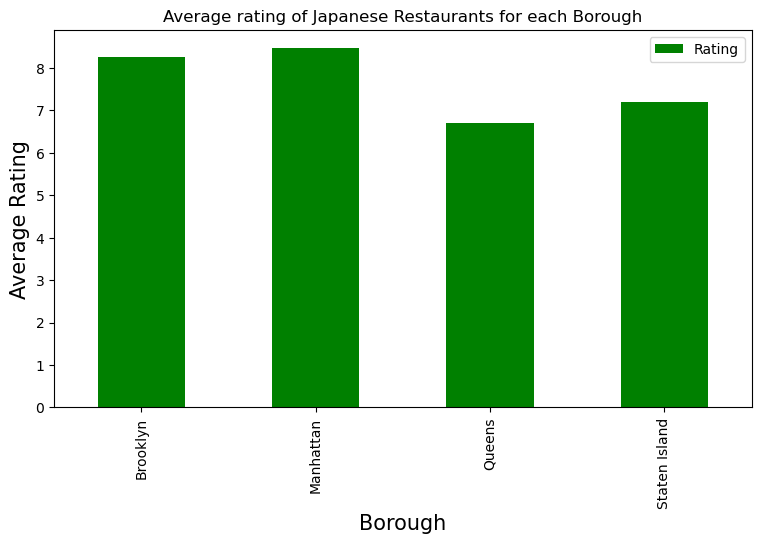

In [36]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [37]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats


,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.300
1,Boerum Hill,8.900
2,Brooklyn Heights,8.300
4,Carroll Gardens,8.000
6,Chelsea,8.800
8,Cobble Hill,8.900
9,Downtown,8.900
10,East Village,9.300
11,Fort Hamilton,8.100
14,Greenwich Village,8.300



We will join this Dataset to original New York data to get longitude and latitude

In [38]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.300
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.900
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.300
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.000
4,Manhattan,Chelsea,40.744035,-74.003116,8.800
5,Staten Island,Chelsea,40.594726,-74.189560,8.800
6,Brooklyn,Cobble Hill,40.687920,-73.998561,8.900
7,Brooklyn,Downtown,40.690844,-73.983463,8.900
8,Manhattan,East Village,40.727847,-73.982226,9.300
9,Brooklyn,Fort Hamilton,40.614768,-74.031979,8.100


In [39]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [40]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results / Conclusion

Manhattan and Brooklyn have the best rated Japanese restaurants on average. Staten Island and The Bronx have the least amount of Japanese restaurants per borough. However, of note, Murray Hill in Manhattan has the highest number of Japanese Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of Japanese restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for Japanese cuisine in NYC. To have the best shot of success, I would open a Japanese restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of Japanese restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to OOTOYA in Manhattan for the best Japanese food based on 1213 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.